In [35]:
#generate_interaction_features
import pandas as pd
from itertools import combinations

def generate_interaction_features(df, features, max_interactions=None, sep="_"):
    cat_features = [f for f in features if df[f].dtype in ['object', 'category']]
    feature_pairs = list(combinations(cat_features, 2))
    
    if max_interactions is not None:
        feature_pairs = feature_pairs[:max_interactions]
    
    for f1, f2 in feature_pairs:
        new_col_name = f"{f1}{sep}{f2}"
        # Создаем числовое представление взаимодействия
        df[new_col_name] = (df[f1].astype(str) + sep + df[f2].astype(str)).factorize()[0]
    
    return df

In [36]:
#plot_shap_beeswarm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib as mpl
from matplotlib.patches import Patch
from typing import Optional, Literal

#TODO: Добавить предварительное сэмплирование, если на вход подан слишком большой датасет.
def plot_shap_beeswarm(
        df: pd.DataFrame,
        feature_names: Optional[list[str]] = None,
        shap_values: object = None,
        max_features: int = 20,
        cat_feature_threshold: float = 0.01,
        figsize: tuple[int, int] = (10, 6),
        n_samples: int = 1_000,
        palette_num: str | list = "coolwarm",
        palette_cat: str | list = "tab20",
        zero_line_color: str = "red",
        title: Optional[str] = None,
        rare_policy: Literal["combine", "drop"] = "combine",
        random_state: int = 8792,
        alpha: float = 0.7,
) -> pd.DataFrame:
    """
    Строит расширенный beeswarm-график SHAP значений с поддержкой категориальных признаков,
    отображением пропусков (NaN), цветовой нормализацией и контролируемой выборкой.
    Все уникальные значения категориальных признаков становятся отдельными признаками с именем в формате
    "родитель#категория".
    Для них строятся boxplot c усами по всему диапазону (min, max).
    Для категорий родителя вводится порог частоты для определения редких категорий (cat_feature_threshold).
    Если в параметре `rare_policy`='drop', то редкие категории удаляются, если 'combine', то создается
    признак "родитель#COMBINED_RARE".
    Все признаки, полученные от одного родителя, красятся в одинаковый цвет.

    :param df: Оригинальный DataFrame с признаками.
    :param feature_names: Список признаков для отображения. Если None — используются все.
    :param shap_values: SHAP-значения, соответствующие df по размеру (может быть DataFrame или ndarray).
    :param max_features: Максимальное количество признаков (или категорий) для отображения.
    :param cat_feature_threshold: Порог для определения редких категорий (по доле).
    :param figsize: Размер графика в дюймах (ширина, высота).
    :param n_samples: Количество наблюдений для отображения (сэмплируется).
    :param palette_num: Цветовая палитра или colormap для числовых признаков.
    :param palette_cat: Цветовая палитра для категориальных признаков.
    :param zero_line_color: Цвет вертикальной линии SHAP=0.
    :param title: Заголовок графика (опционально). Если None, то не отображается.
    :param rare_policy: Политика обработки редких категорий: 'combine' — объединить, 'drop' — удалить.
    :param random_state: Начальное значение генератора случайных чисел (для воспроизводимости).
    :param alpha: Прозрачность точек и boxplot (от 0 до 1).
    :return: DataFrame, содержащий точки для построения графика (после обработки и сэмплирования).
    """

    rng = np.random.default_rng(random_state)

    # Преобразуем SHAP-массив в DataFrame (если передан np.ndarray)
    if isinstance(shap_values, np.ndarray):
        shap_df = pd.DataFrame(shap_values, index=df.index, columns=df.columns)
    else:
        shap_df = shap_values.copy()

    # Проверка на соответствие форм и корректность параметров
    if shap_df.shape != df.shape:
        raise ValueError("Shape mismatch between df and shap_values.")
    if not (0 < cat_feature_threshold < 1):
        raise ValueError("cat_feature_threshold must be between 0 and 1.")
    if rare_policy not in {"combine", "drop"}:
        raise ValueError("rare_policy must be 'combine' or 'drop'.")
    if not (0 <= alpha <= 1):
        raise ValueError("alpha must be between 0 and 1.")

    # Сужаем датафрейм до выбранных признаков
    if feature_names:
        parents = [f for f in feature_names if f in df.columns]
    else:
        parents = list(df.columns)
    df = df[parents]
    shap_df = shap_df[parents]

    # Разделяем признаки на числовые и категориальные
    num_cols = [f for f in parents if df[f].dtype.name not in {"object","category"}]
    cat_cols = [f for f in parents if f not in num_cols]

    # Расширяем категориальные признаки: делаем отдельные колонки SHAP-значений на каждую категорию
    expanded = {}
    for f in cat_cols:
        series = df[f].astype(object)
        freq = series.value_counts(dropna=False, normalize=True)
        rare = freq[freq < cat_feature_threshold].index
        proc = series.where(~series.isin(rare), "COMBINED_RARE") if rare_policy=="combine" else series[~series.isin(rare)]
        proc = proc.fillna("NaN")
        shap_col = shap_df[f]
        for cat in proc.unique():
            expanded[f"{f}#{cat}"] = shap_col.where(proc==cat)

    # Для числовых признаков просто копируем SHAP значения
    for f in num_cols:
        expanded[f] = shap_df[f]
    shap_expanded = pd.DataFrame(expanded)

    # Сортировка признаков по среднему абсолютному SHAP влиянию
    mean_abs = shap_expanded.abs().mean().sort_values(ascending=False)
    ordered = list(mean_abs.index)[:max_features]

    # Подготовка данных для отображения: выборка сэмплов и нормализация
    records = []
    norm_map = {f: df[f].rank(pct=True) for f in num_cols} # приведение к равномерному распределению. TODO: потом сделаю умнее
    for feat in ordered:
        vals = shap_expanded[feat].dropna()
        idx = rng.choice(vals.index, min(len(vals), n_samples), replace=False)
        is_cat = feat not in num_cols
        for i in idx:
            base_feat = feat.split("#", 1)[0] if is_cat else feat
            orig_val = df[base_feat].loc[i]
            norm_val = np.nan if is_cat else norm_map[feat].loc[i]
            is_nan = pd.isna(orig_val)
            records.append({
                'feature': feat,
                'shap': vals.loc[i],
                'norm_val': norm_val,
                'is_cat': is_cat,
                'is_nan': is_nan,
                'cat_value': (feat.split('#', 1)[1] if is_cat else np.nan)
            })
    plot_df = pd.DataFrame(records)
    plot_df['feature'] = pd.Categorical(plot_df['feature'], categories=ordered, ordered=True)

    # Настройка цвета: градиент для числовых, цветовая палитра для категориальных
    num_norm = Normalize(vmin=0, vmax=1)
    cmap_num = mpl.colormaps.get_cmap(palette_num) if isinstance(palette_num,str) else palette_num
    parent_cat_features = sorted({c.split('#', 1)[0] for c in ordered if '#' in c})
    cat_palette_used = sns.color_palette(palette_cat, len(parent_cat_features)) if isinstance(palette_cat,str) else palette_cat
    parent_color_map = dict(zip(parent_cat_features, cat_palette_used))

    # Построение графика
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    ax = fig.add_axes([0.05,0.15,0.6,0.75])

    # Boxplot'ы для категориальных признаков
    for i, feat in enumerate(ordered):
        if feat not in num_cols:
            dfc = plot_df[plot_df.feature==feat]
            parent = feat.split('#', 1)[0]
            vals = dfc.shap.values
            bp = ax.boxplot(
                vals,
                positions=[i],
                vert=False,
                widths=0.6,
                patch_artist=True,
                whis=(0, 100),
                zorder=2
            )
            for box in bp['boxes']:
                box.set_facecolor(parent_color_map[parent])
                box.set_alpha(alpha)
            for whisker in bp['whiskers']:
                whisker.set_color(parent_color_map[parent])
            for cap in bp['caps']:
                cap.set_color(parent_color_map[parent])
            for median in bp['medians']:
                median.set_color('black')

    # Scatter точки для числовых признаков: джиттер + отдельный рендер NaN
    for i, feat in enumerate(ordered):
        if feat in num_cols:
            # Точки с известными значениями
            df_num = plot_df[(plot_df.feature == feat) & (~plot_df.is_nan)]
            if not df_num.empty:
                y_jitter = i + (rng.random(len(df_num)) - 0.5) * 0.4
                ax.scatter(
                    df_num.shap,
                    y_jitter,
                    c=[cmap_num(num_norm(v)) for v in df_num.norm_val],
                    s=20,
                    alpha=alpha,
                    linewidths=0,
                    zorder=3
                )
            # Черные точки для NaN (без джиттера)
            df_nan_num = plot_df[(plot_df.feature == feat) & (plot_df.is_nan)]
            if not df_nan_num.empty:
                ax.scatter(
                    df_nan_num.shap,
                    [i] * len(df_nan_num),
                    c='black',
                    s=20,
                    alpha=alpha,
                    linewidths=0,
                    zorder=4
                )

    # Вертикальная линия SHAP = 0
    ax.axvline(0, color=zero_line_color, linewidth=1.5, zorder=1)

    # Подписи по оси Y
    y_labels=[]
    for feat in ordered:
        if '#' in feat:
            pre,cat=feat.split('#',1)
            safe_pre=pre.replace('_', '\\_').replace(' ', '\\ ')
            safe_cat=cat.replace('_', '\\_').replace(' ', '\\ ')
            y_labels.append(r"$\mathbf{"+safe_pre+r"}\#\mathrm{"+safe_cat+r"}$")
        else:
            sf=feat.replace('_','\\_').replace(' ','\\ ')
            y_labels.append(r"$\mathbf{"+sf+r"}$")
    ax.set_yticks(range(len(ordered)))
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('SHAP values')
    ax.set_ylabel('Feature')
    ax.grid(axis='x', linestyle='--', alpha=0)
    if title:
        ax.set_title(title, fontsize=14)

    # Цветовая шкала для числовых признаков
    sm=mpl.cm.ScalarMappable(cmap=cmap_num, norm=num_norm)
    sm.set_array([])
    cax=fig.add_axes([0.68,0.15,0.02,0.75])
    cbar=fig.colorbar(sm, cax=cax)

    # Легенда для категорий и NaN
    legend_elems=[Patch(facecolor='black', label='NaN')]+[Patch(facecolor=parent_color_map[p], label=p) for p in parent_cat_features]
    fig.legend(
        handles=legend_elems,
        title='Categories',
        bbox_to_anchor=(0.75,0.5),
        loc='center left',
        frameon=False
    )

    return plot_df


In [37]:
class EpsilonLossObjective(object):
    def __init__(self, alpha=1.2, beta=0.9, epsilon=1.0, p=2):
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.p = p
    
    def calc_ders_range(self, approxes, targets, weights):
        grad = np.zeros(len(targets), dtype=np.float64)
        hess = np.zeros(len(targets), dtype=np.float64)
        
        residuals = np.array(approxes) - np.array(targets)
        
        within_epsilon = np.abs(residuals) <= self.epsilon
        overestimation = residuals > self.epsilon
        underestimation = residuals < -self.epsilon
        
        # Градиент
        grad[overestimation] = self.alpha * self.p * (residuals[overestimation] - self.epsilon)**(self.p - 1)
        grad[underestimation] = -self.beta * self.p * (-residuals[underestimation] - self.epsilon)**(self.p - 1)
        
        # Гессиан (только если p > 1)
        if self.p > 1:
            hess[overestimation] = self.alpha * self.p * (self.p - 1) * (residuals[overestimation] - self.epsilon)**(self.p - 2)
            hess[underestimation] = self.beta * self.p * (self.p - 1) * (-residuals[underestimation] - self.epsilon)**(self.p - 2)
        
        # Защита от численной нестабильности
        grad = np.nan_to_num(grad, nan=0.0, posinf=0.0, neginf=0.0)
        hess = np.nan_to_num(hess, nan=0.0, posinf=0.0, neginf=0.0)
        
        return list(zip(grad, hess))

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from functools import partial

# Загрузка данных
train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')

# Подготовка данных
features = list(train.drop('target', axis=1).columns)
cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Преобразование категориальных признаков
cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

for feat in cat_features:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')

In [39]:
#train = train.sample(1000)

In [ ]:
# Лучшие параметры из Optuna
best_params = {
    #'loss_function': EpsilonLossObjective(alpha=1.4, beta=1.55, epsilon=25, p=1.83),
    'loss_function': 'RMSE',
    'iterations': 1146,
    'learning_rate': 0.09652479858727847,
    'depth': 7,
    'l2_leaf_reg': 4.130523663958776,
    'random_strength': 0.07304403301548891,
    'bagging_temperature': 0.5696363378933689,
    'leaf_estimation_iterations': 7,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': False
}

# Кросс-валидация
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(train[features]), 1):
    X_train, X_valid = train[features].iloc[train_idx], train[features].iloc[valid_idx]
    y_train, y_valid = train['target'].iloc[train_idx], train['target'].iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    
    model = CatBoostRegressor(**best_params)
    model.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=50,
        verbose=False
    )
    
    valid_pred = model.predict(X_valid)
    oof_preds[valid_idx] = valid_pred
    test_preds += model.predict(test[features]) / n_folds
    
    rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    scores.append(rmse)
    print(f'Fold {fold} RMSE: {rmse:.4f}')

print(f'\nAverage RMSE across folds: {np.mean(scores):.4f}')
print(f'Standard deviation: {np.std(scores):.4f}')

# Обучение финальной модели на всех данных
full_train_pool = Pool(train[features], train['target'], cat_features=cat_features)
final_model = CatBoostRegressor(**best_params)
final_model.fit(full_train_pool)

# Предсказание на тестовых данных
test['target'] = final_model.predict(test[features])
test[['index', 'target']].to_csv('catboost_cv_after_opt.csv', index=False)

c:\Users\Admin\anaconda3\Lib\site-packages\catboost\core.py:2321: UserWarning: Can't optimze method "calc_ders_range" because self argument is used
  _check_train_params(params)


CatBoostError: catboost/python-package/catboost/helpers.cpp:57: Traceback (most recent call last):
  File "_catboost.pyx", line 1630, in _catboost._ObjectiveCalcDersRange
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_35204\1853566927.py", line 12, in calc_ders_range
    residuals = np.array(approxes) - np.array(targets)
                                     ^^^^^^^^^^^^^^^^^
KeyboardInterrupt


In [ ]:
test.target

0        4.214081e+19
1       -5.050814e+16
2        6.063867e+20
3       -1.399405e+22
4        9.155734e+14
             ...     
51764    6.723608e+20
51765    3.060569e+20
51766    8.396654e+19
51767    6.063866e+20
51768    3.550766e+19
Name: target, Length: 51769, dtype: float64

In [ ]:
s

NameError: name 's' is not defined

In [ ]:
import shap

# Инициализация explainer
explainer = shap.TreeExplainer(final_model)

# Вычисление SHAP-значений для тренировочных данных
shap_values = explainer.shap_values(train[features])

# Если данных много, можно сэмплировать для ускорения
sample_idx = np.random.choice(train.shape[0], size=1000, replace=False)
shap_values_sample = explainer.shap_values(train[features].iloc[sample_idx])

ValueError: Cannot take a larger sample than population when 'replace=False'

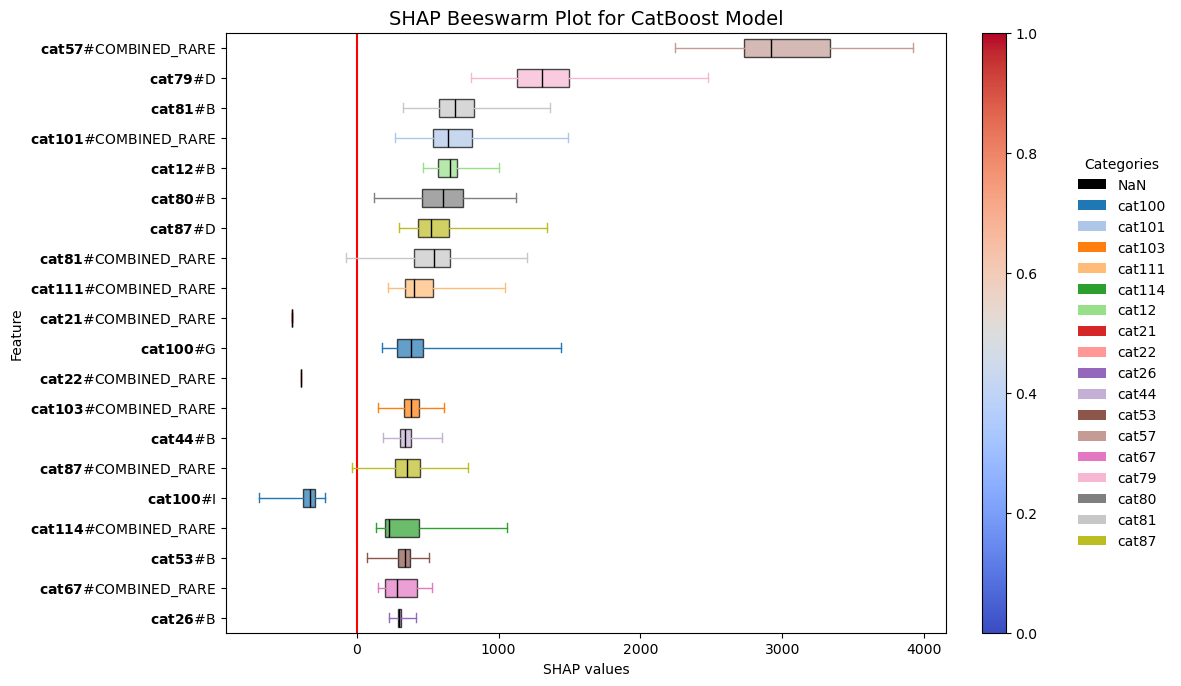

In [ ]:
# Вызов функции визуализации
plot_df = plot_shap_beeswarm(
    df=train[features].iloc[sample_idx],  # Используем тот же сэмпл
    feature_names=features,  # Все фичи или можно передать топ-N
    shap_values=shap_values_sample,
    max_features=20,  # Ограничиваем количество фич для визуализации
    cat_feature_threshold=0.05,  # Порог для редких категорий
    figsize=(12, 8),
    n_samples=1000,
    title="SHAP Beeswarm Plot for CatBoost Model"
)

plt.show()